## 单输入 & 截断输出

单输入截断输出是常见的需求之一，用于从模型中提取中间某一层的特征，频繁出现的例子有：  
* 1.输入一张图片，输出这个图片的类别【主输出】 & 输出最后一层卷积层提取的特征【截断输出】。
* 2.输入一句话，输出这句话的态度（积极或消极） & 输出说这句话最有可能的性别（男或女）  

这里的例子是第一个

In [1]:
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.datasets import mnist

import numpy as np
import matplotlib.pyplot as plt

## 载入数据

In [2]:
(x_train, y_train), (_, _) = mnist.load_data()

x_train = x_train / 255.0
y_train = to_categorical(y_train, num_classes=10)

## 模型主体

In [3]:
input_layer = Input(shape=(28, 28, 1))            # 模型开头最好用Input层

conv_1 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(input_layer)
conv_2 = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(conv_1)

conv_3 = Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(conv_2)
conv_4 = Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(conv_3)

conv_5 = Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(conv_4)
conv_6 = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(conv_5)
maxp_3 = MaxPooling2D()(conv_6)

# 假设conv_last是我们希望截获的层，对于初学者来说，想要提取哪层就单独给这层name赋值
# 但实际上每一层都应该指定name，后期会深入讨论为什么这么做
conv_last = Conv2D(filters=64, kernel_size=(3,3), activation='relu', name='conv_last')(maxp_3)   
flatten = Flatten()(conv_last)
dense_1 = Dense(32, activation='relu')(flatten)
dense_last = Dense(10, activation='softmax')(dense_1)

按照下面顺序先定义主模型，再定义截断模型。截断模型实际上使用的是主模型参数及权重。  

In [4]:
model = Model(inputs=input_layer, outputs=dense_last)    # 首先定义主模型
interp_model = Model(inputs=input_layer, outputs=model.get_layer('conv_last').output)  # 然后定义截断模型

## 训练 & 编译 主模型

经过这种定义方法后，我们只需要关注主模型的编译及训练

In [5]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [6]:
model.fit(x_train, y_train, epochs=5, batch_size=256, verbose=1)

Epoch 1/5
235/235 [==============================] - 66s 245ms/step - loss: 0.4799 - accuracy: 0.8395
Epoch 2/5
235/235 [==============================] - 55s 235ms/step - loss: 0.0529 - accuracy: 0.9838
Epoch 3/5
235/235 [==============================] - 56s 237ms/step - loss: 0.0309 - accuracy: 0.9906
Epoch 4/5
235/235 [==============================] - 55s 234ms/step - loss: 0.0257 - accuracy: 0.9918
Epoch 5/5
235/235 [==============================] - 55s 235ms/step - loss: 0.0176 - accuracy: 0.9948


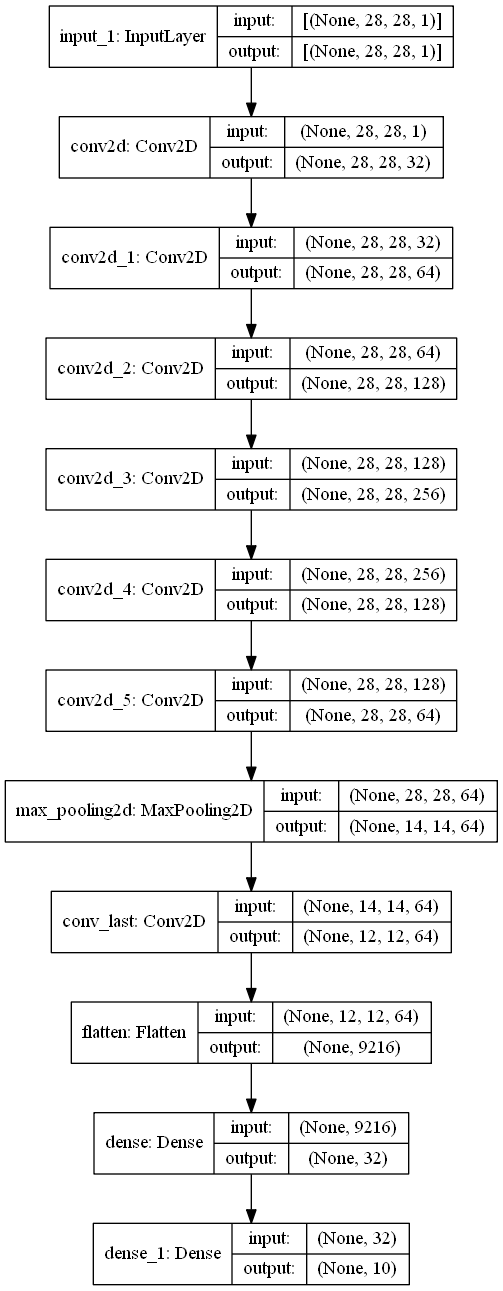

In [7]:
plot_model(model, show_shapes=True)

## 查看某张图片的输出特征

In [8]:
interp_out = interp_model.predict(x_train[0:1])
interp_out.shape

(1, 12, 12, 64)

抽查其中一个卷积核提出取来的特征

Text(0.5, 1.0, 'one of filters features')

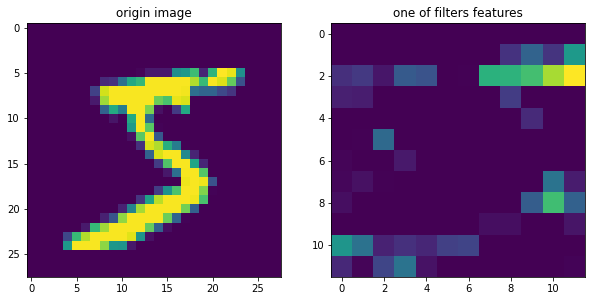

In [13]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(x_train[0])
plt.title('origin image')

plt.subplot(1,2,2)
plt.imshow(interp_out[0, :, :, 0])
plt.title('one of filters features')